In [1]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import os
import sys
import shutil
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [2]:
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)

df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)

df.head()

,volume,area,n_triangles,x_scale,y_scale,z_scale,area_ratio_xy,area_ratio_xz,area_ratio_yz,build_time,support_material,model_material,area_ground,box_volume
0,98.344215,420.096211,652,9.144006,0.50800,22.013333,2.398148,1.923505,1.999995,435,40.950,109.838,4.645153,102.255309
1,3.726959,26.368342,564,6.032647,1.15000,1.234622,1.216648,1.991790,2.678573,30,3.159,5.057,6.937544,8.565246
2,1.315050,11.516920,2454,1.650000,1.65000,1.390008,1.028467,2.060714,2.113780,28,2.860,2.563,2.722500,3.784297
3,4.134664,20.899255,1152,2.000000,2.25849,1.650000,2.081730,1.906478,1.953626,29,2.524,5.198,4.516980,7.453017
4,927.755856,1253.666592,31880,25.400000,25.40000,8.375590,0.727910,3.029799,3.045351,766,31.157,874.206,645.160000,5403.595894


In [3]:
#Extract build times
dfcopy = df.copy()
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)
build_times.head()

0    435
1     30
2     28
3     29
4    766
Name: build_time, dtype: int64

In [4]:
#Train/test split
xtrain, xtest, ytrain, ytest = train_test_split(df, build_times, test_size=0.3)

In [5]:
#Make pipeline
#https://joaquinamatrodrigo.github.io/skforecast/0.5.1/user_guides/sklearn-transformers-and-pipeline.html

def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 

#normalizer = Normalizer()
scaler = MinMaxScaler()
logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer), ('scaler', scaler)])

In [6]:
#Xdata pipe fit

xlabels = xtrain.columns.values

xtrain = pipe.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain)
xtrain.columns = xlabels

print(xtest.head())
xtest = pipe.transform(xtest)
xtest = pd.DataFrame(xtest)
xtest.columns = xlabels
print(xtest.head())

         volume       area  n_triangles   x_scale   y_scale   z_scale  \
819   11.464214  32.458459        19744  1.862667  1.947333  4.131733   
570    8.206220  43.408105         1436  3.800000  4.700000  0.948700   
194    4.256606  64.014673          308  5.603150  4.637696  0.434496   
3573   8.704185  52.497251         1730  2.250000  4.015765  8.344839   
3333   7.169913  80.158564         2878  4.400000  6.300000  2.000000   

      area_ratio_xy  area_ratio_xz  area_ratio_yz  support_material  \
819        2.026171       2.060653       2.027228            10.540   
570        1.613938       2.906723       2.257142             2.820   
194        1.998457       3.066031       3.013154             4.980   
3573       2.494142       1.145483       0.673856            14.866   
3333       1.554922       2.516468       1.923357             1.776   

      model_material  area_ground  box_volume  
819           15.342     3.627233   14.986759  
570            8.883    17.860000   16

In [7]:
#Convert to tensors
xtraint = tf.convert_to_tensor(xtrain)
ytraint = tf.convert_to_tensor(ytrain)
xtestt = tf.convert_to_tensor(xtest)
ytestt = tf.convert_to_tensor(ytest)

In [8]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-6, patience=patience//2, verbose=1)]

In [185]:
#Single layer tuner
#https://www.analyticsvidhya.com/blog/2021/06/keras-tuner-auto-neural-network-architecture-selection/

#Remove old search
try:
    shutil.rmtree("single_layer_tuning")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(13,))

  hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  
  model.add(tf.keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mae', metrics = ['mape'])
  return model

tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_mae',
    max_trials = 10,
    executions_per_trial = 3,
    project_name = "single_layer_tuning"
)

tuner.search_space_summary()

Error: single_layer_tuning - Het systeem kan het opgegeven pad niet vinden.
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [186]:
#Search
tuner.search(xtraint, ytraint, epochs=5, validation_data=(xtestt, ytestt))

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 01m 37s
INFO:tensorflow:Oracle triggered exit


In [187]:
#Results
tuner.results_summary(1)

Results summary
Results in .\single_layer_tuning
Showing 1 best trials
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.0001
Score: 0.0


In [9]:
#Multiple layer tuner
#https://www.analyticsvidhya.com/blog/2021/06/keras-tuner-auto-neural-network-architecture-selection/
#https://pub.towardsai.net/keras-tuner-tutorial-hyperparameter-optimization-tensorflow-keras-computer-vision-example-c9abbdad9887

#Remove old search
try:
    shutil.rmtree("multiple_layers_tuning")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))


def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(13,))

  hp_layers = hp.Int("layers", min_value=1, max_value=5, step=1)
  
  for i in range(hp_layers):
    model.add(tf.keras.layers.Dense(units=hp.Int(f"units_{i}", min_value=8, max_value=256, step=16), activation='relu'))

  
  model.add(tf.keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'mape', metrics = ['mae', 'mape'])
  return model

tuner = kt.BayesianOptimization(
    model_builder,
    objective = 'val_mape',
    max_trials = 10,
    executions_per_trial = 3,
    project_name = "multiple_layers_tuning"
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [10]:
#Search
tuner.search(xtraint, ytraint, epochs=5, validation_data=(xtestt, ytestt), callbacks=get_callbacks('NN_weights.h5',
                                                                                                    patience=10,
                                                                                                    lr_factor=0.2))

Trial 10 Complete [00h 00m 12s]
val_mape: 45.15690612792969

Best val_mape So Far: 30.160851160685223
Total elapsed time: 00h 02m 33s
INFO:tensorflow:Oracle triggered exit


In [11]:
#Results
tuner.results_summary(1)

Results summary
Results in .\multiple_layers_tuning
Showing 1 best trials
Trial summary
Hyperparameters:
layers: 4
units_0: 248
learning_rate: 0.01
units_1: 248
units_2: 248
units_3: 8
units_4: 232
Score: 30.160851160685223


In [10]:
#Build new model
model = tf.keras.Sequential([
                               tf.keras.layers.Input(13,),
                               tf.keras.layers.Dense(8, activation='relu'),
                               tf.keras.layers.Dense(24, activation='relu'),
                               tf.keras.layers.Dense(136, activation='relu'),
                               tf.keras.layers.Dense(232, activation='relu'),
                               tf.keras.layers.Dense(232, activation='relu'),
                               tf.keras.layers.Dense(1)
])
model.compile(loss='mape',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=['mae',tf.keras.metrics.MeanAbsolutePercentageError(name="mape")]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 112       
                                                                 
 dense_6 (Dense)             (None, 24)                216       
                                                                 
 dense_7 (Dense)             (None, 136)               3400      
                                                                 
 dense_8 (Dense)             (None, 232)               31784     
                                                                 
 dense_9 (Dense)             (None, 232)               54056     
                                                                 
 dense_10 (Dense)            (None, 1)                 233       
                                                                 
Total params: 89,801
Trainable params: 89,801
Non-trai

In [ ]:
#Naive fit model
model.fit(xtraint, ytraint, epochs=400, verbose=0)

In [52]:
#Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(1)
best_hps[0].values

{'layers': 2, 'units_0': 104, 'learning_rate': 0.01, 'units_1': 8}

In [122]:
#Test new model
preds = model.predict(xtestt)

mae = tf.metrics.mean_absolute_error(y_true=ytestt, y_pred=preds.squeeze()).numpy()
print(f"Mean absolute error: {mae}")

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(y_true=ytestt, y_pred=preds.squeeze())
print(f"Mean percentage error: {m.result().numpy()}")


35/35 [==============================] - 0s 2ms/step
Mean absolute error: 21.534584045410156
Mean percentage error: 12.700477600097656


In [11]:
#Fit with callbacks
history = model.fit(xtraint, ytraint, validation_data=(xtestt, ytestt), epochs=400, verbose=0,
                    callbacks=get_callbacks('savedmodels/Baseline',
                                            patience=10,
                                            lr_factor=0.2))



INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: savedmodels\Baseline\assets
INFO:tensorflow:Assets written to: saved

In [12]:
#Test new model
preds = model.predict(xtestt)

mae = tf.metrics.mean_absolute_error(y_true=ytestt, y_pred=preds.squeeze()).numpy()
print(f"Mean absolute error: {mae}")

mape = tf.metrics.mape(y_true=ytestt, y_pred=preds.squeeze())
print(f"Mean percentage error: {mape}")

35/35 [==============================] - 0s 4ms/step
Mean absolute error: 38.28886032104492
Mean percentage error: 10.420564651489258


<function matplotlib.pyplot.show(close=None, block=None)>

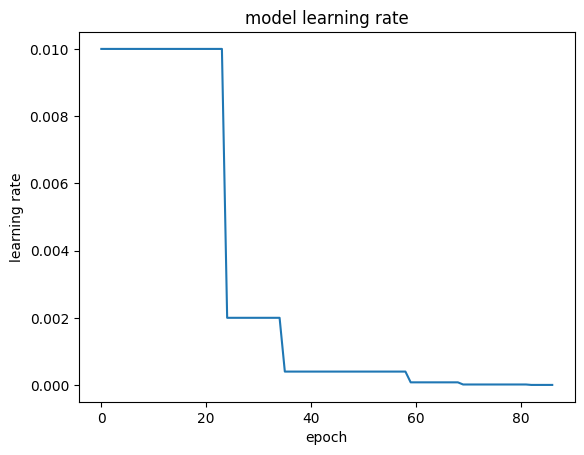

In [13]:
#Plot learning rate
plt.plot(history.history["lr"])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

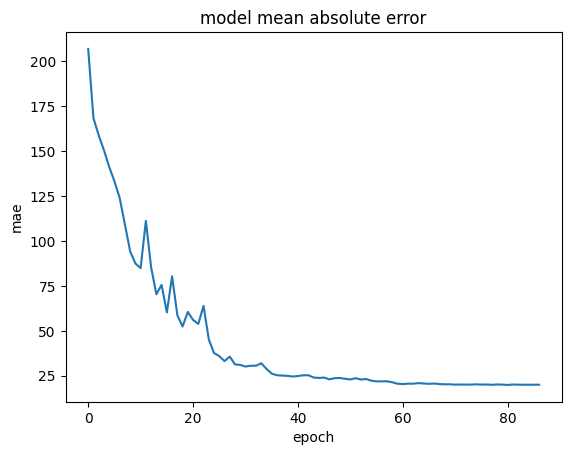

In [14]:
#Plot mae
plt.plot(history.history["mae"])
plt.title('model mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show